# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [5]:
# all import statements needed for the project, for example:
import os
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import sqlalchemy as db
from sqlalchemy import text
from bs4 import BeautifulSoup
import re
from datetime import datetime
from typing import List
!pip install geopandas
import geopandas as gpd
import math
import numpy as np
import sqlite3
import scipy.stats as stats
from sqlalchemy import create_engine
from scipy.stats import norm
from typing import Union

In [7]:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = r"./taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = r"./raw_weather_data"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [9]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### 1.1 Load Taxi Zones

#### 1.1.1 Loading the taxi_zone shapefile

In [15]:
def load_taxi_zones(shapefile):
    """
    Load taxi zones data from a shapefile.

    Parameters:
    shapefile (str): The file path to the taxi zones shapefile.

    Returns:
    GeoDataFrame: A GeoPandas GeoDataFrame containing the taxi zones data if loading is successful.
                  Returns None if an error occurs.
    """
    try:
        # Attempt to load the shapefile into a GeoPandas GeoDataFrame
        taxi_zones = gpd.read_file(shapefile)

        # Print a success message with the number of zones loaded
        print(f"Taxi Zones data loaded successfully. Total zones: {len(taxi_zones)}")

        # Return the loaded GeoDataFrame
        return taxi_zones
    except Exception as e:
        # Handle any errors that occur during loading and print the error message
        print(f"Error loading Taxi Zones shapefile: {e}")

        # Return None to indicate failure
        return None

#### 1.1.2 Look up the latitude and longitude for a given Taxi Zone location ID and return  latitude, longitude of location ID

In [25]:
def lookup_coords_for_taxi_zone_id(
    zone_loc_id: int, 
    loaded_taxi_zones: gpd.GeoDataFrame
): 
    """
    Look up the coordinates (latitude and longitude) for a given taxi zone Location ID.

    Parameters:
    zone_loc_id (int): The Location ID of the taxi zone to look up.
    loaded_taxi_zones (gpd.GeoDataFrame): A GeoPandas GeoDataFrame containing taxi zone geometries and attributes.

    Returns:
    Optional[Tuple[float, float]]: A tuple (latitude, longitude) of the centroid of the taxi zone geometry if found.
                                   Returns None if the Location ID is not found or an error occurs.
    """
    try:
        # Convert the GeoDataFrame to the WGS84 coordinate reference system (EPSG:4326).
        loaded_taxi_zones = loaded_taxi_zones.to_crs(epsg=4326)

        # Find the row corresponding to the provided Location ID.
        zone = loaded_taxi_zones.loc[loaded_taxi_zones['LocationID'] == zone_loc_id]
        
        # If no match is found, return None.
        if zone.empty:
            print(f"Location ID {zone_loc_id} not found.")
            return None
        
        # Extract the longitude and latitude of the zone's centroid.
        lon = zone.geometry.centroid.x.values[0]
        lat = zone.geometry.centroid.y.values[0]
        
        # Return the coordinates as a tuple.
        return lat, lon

    except Exception as e:
        # Handle any exceptions and print an error message.
        print(f"Error occurred while looking up coordinates: {e}")
        return None

#### 1.1.3 Downloading coordinates of Taxi Zone  to csv file

In [28]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Look up the coordinates (latitude and longitude) for a given taxi zone Location ID.

    Parameters:
    zone_loc_id (int): The Location ID of the taxi zone to look up.
    loaded_taxi_zones (GeoDataFrame): A GeoPandas GeoDataFrame containing taxi zone geometries and attributes.

    Returns:
    tuple: A tuple (latitude, longitude) representing the coordinates of the centroid of the taxi zone.
           Returns None if the Location ID is not found or an error occurs.
    """

    try:
        # Convert the GeoDataFrame's coordinate reference system (CRS) to WGS84 (EPSG:4326)
        # which uses latitude and longitude. This ensures consistency in geographic coordinates.
        loaded_taxi_zones = loaded_taxi_zones.to_crs(epsg=4326)

        # Filter the GeoDataFrame to find the row corresponding to the specified Location ID.
        zone = loaded_taxi_zones.loc[loaded_taxi_zones['LocationID'] == zone_loc_id]
        
        # Check if the filtered GeoDataFrame is empty, indicating the Location ID was not found.
        if zone.empty:
            print(f"Location ID {zone_loc_id} not found.")
            return None  # Return None if no matching Location ID exists.
        
        # Calculate the longitude (x) and latitude (y) of the centroid of the zone's geometry.
        lon = zone.geometry.centroid.x.values[0]
        lat = zone.geometry.centroid.y.values[0]
        
        # Return the coordinates as a tuple (latitude, longitude).
        return lat, lon

    except Exception as e:
     
        print(f"Error occurred while looking up coordinates: {e}")
        return None

### 1.2 Calculate Sample Size

In [31]:
def calculate_sample_size(population, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):

    z_scores = {
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.576
    }   
    # Get the Z-score for the desired confidence level
    Z = z_scores.get(confidence_level, 1.96)  # Default to 95% confidence if not found
    
    # Cochran's sample size formula (n0)
    n0 = (Z ** 2 * proportion * (1 - proportion)) / (margin_of_error ** 2)
    
    # Adjust for finite population if necessary
    if population < 1000:  # If population is small, apply finite population correction
        n = n0 / (1 + (n0 - 1) / population)
    else:
        n = n0
    
    return math.ceil(n)  # Round up to ensure the sample size is sufficient


### 1.2 Common Functions : YELLOW TAXI

##### 1.2.1 Defining get_taxi_html funtion to get the content from NewYork Taxi Trip Reports

In [72]:
def get_taxi_html() -> str:
    response = requests.get(TAXI_URL)
    response.raise_for_status()
    html = response.content
    return html


##### 1.2.2. The function to find the parquet links of  the Only Yellow Taxi trip

In [75]:
def find_taxi_parquet_links() -> List[str]:
    """
    Find and filter links to Yellow Taxi Trip parquet files.

    Returns:
    List[str]: A list of URLs pointing to Yellow Taxi Trip parquet files, filtered by date.
    """
    # Fetch the HTML content from the target website
    html = get_taxi_html()  # Assumes get_taxi_html() retrieves the HTML of the webpage.

    # Parse the HTML content using BeautifulSoup
    soup = bs4.BeautifulSoup(html, "html.parser")

    # Find all <a> tags with the specified "title" attribute (Yellow Taxi Trip Records).
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    
    # Store all the matching <a> tags (in this case, it's the same as yellow_a_tags).
    all_a_tags = yellow_a_tags

    # Extract and clean the 'href' attributes for links containing ".parquet".
    parquet_links = [
        a["href"].strip() for a in all_a_tags if ".parquet" in (a.get("href") or "")
    ]

    # Filter the list of links by date (assumes filter_links_by_date() applies date-based filtering).
    return filter_links_by_date(parquet_links)

##### 1.2.3 The function to filter required dates for our Project's data

In [78]:
def filter_links_by_date(links: List[str]) -> List[str]:
    """
    Filter Parquet file links by date, retaining only those within the specified range.

    Parameters:
    links (List[str]): A list of Parquet file URLs to filter.

    Returns:
    List[str]: A filtered list of links that fall within the specified date range.
    """
    filtered_links = []  # Initialize an empty list to store valid links.
    
    # Define a regex pattern to extract the year and month from the filename.
    # Example match: "_2024-03.parquet" captures 2024 as the year and 03 as the month.
    date_pattern = re.compile(r"_(\d{4})-(\d{2})\.parquet")
    
    for link in links:
        # Search for the date pattern in the link.
        match = date_pattern.search(link)
        if match:
            # Extract the year and month from the matched pattern.
            year, month = int(match.group(1)), int(match.group(2))

            # Create a datetime object for the extracted date.
            file_date = datetime(year, month, 1)

            # Check if the file date falls within the global START_DATE and END_DATE range.
            if START_DATE <= file_date <= END_DATE:
                # Add the link to the filtered list if it meets the criteria.
                filtered_links.append(link)
    
   
    return filtered_links

##### 1.2.4 In our project we are working on the data from Jan/01/2020 till Aug/31/2024

In [81]:
TAXI_URL: str = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Date range for filtering
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2024, 8, 30)

##### 1.2.5 Function to Download the Yellow Taxi Data one time. If there is folder and data, this function will skip downloading for next time

In [84]:
def download_files(links: List[str], folder_name: str) -> None:
    """Download files from a list of links and save them to the specified folder."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}
    
    for link in links:
        file_name = link.split("/")[-1]
        file_path = os.path.join(folder_name, file_name)
        print(f"Downloading {file_name} from {link}...")
        if os.path.exists(file_path):
            print(f"File {file_name} already exists. Skipping download.")
            continue  # Skip to the next file if it already exists
        
        print(f"Downloading {file_name} from {link}...")
        
        # Request with headers to mimic a browser
        response = requests.get(link, headers=headers)
        response.raise_for_status()  # Check if download was successful
        
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")


##### 1.2.6 Downloading the Yellow Taxi Parquet files 

In [87]:
# Find and download filtered links
filtered_links =find_taxi_parquet_links()
download_files(filtered_links, "yellow_taxi")


File yellow_tripdata_2024-01.parquet already exists. Skipping download.
File yellow_tripdata_2024-02.parquet already exists. Skipping download.
File yellow_tripdata_2024-03.parquet already exists. Skipping download.
File yellow_tripdata_2024-04.parquet already exists. Skipping download.
File yellow_tripdata_2024-05.parquet already exists. Skipping download.
File yellow_tripdata_2024-06.parquet already exists. Skipping download.
File yellow_tripdata_2024-07.parquet already exists. Skipping download.
File yellow_tripdata_2024-08.parquet already exists. Skipping download.
File yellow_tripdata_2023-01.parquet already exists. Skipping download.
File yellow_tripdata_2023-02.parquet already exists. Skipping download.
File yellow_tripdata_2023-03.parquet already exists. Skipping download.
File yellow_tripdata_2023-04.parquet already exists. Skipping download.
File yellow_tripdata_2023-05.parquet already exists. Skipping download.
File yellow_tripdata_2023-06.parquet already exists. Skipping do

#### 1.2.7  Sampling the Yellow Taxi Parquet Files

##### 1.2.7.1 Creating and checking the folder which will include the Sampled Yellow Taxi parquets. 

In [89]:
folder_path = r"./yellow_taxi"
sample_folder_path = r"./Sample Yellow Taxi"

# Function to create folder if it doesn't exist
def create_folder_if_not_exists(folder_path: str) -> None:
    """
    Create a folder if it does not already exist.

    Parameters:
    folder_path (str): The path of the folder to create.

    Returns:
    None
    """
    # Check if the folder exists using os.path.exists.
    if not os.path.exists(folder_path):
        # If the folder does not exist, create it using os.makedirs.
        os.makedirs(folder_path)  
        print(f"Folder created: {folder_path}")  # Notify that the folder was created.
    else:
        
        print(f"Folder already exists: {folder_path}")

##### 1.2.7.2 The Function to sample each month parquet file based on the Cochran's Sample size formula. In this project, I assume that confidence level of sample is 0.99 and margin of error is 0.05

In [92]:
def process_and_sample_file(file_path: str, sample_folder_path: str):
    """Read a Parquet file, calculate sample size, and save sampled data to a new file."""
    file_name = os.path.basename(file_path)
    sample_file_name = f"sampled_{file_name}"
    sample_file_path = os.path.join(sample_folder_path, sample_file_name)

    # Check if the sample file already exists
    if os.path.exists(sample_file_path):
        print(f"Sample file {sample_file_name} already exists. Skipping this file.")
        return

    # Read the Parquet file
    month_data = pd.read_parquet(file_path)

    # Get the population size
    population_size = len(month_data)

    # Calculate the sample size
    sample_size = calculate_sample_size(population_size, confidence_level=0.99, margin_of_error=0.05)

    # Sample the data
    sampled_data = month_data.sample(n=sample_size, random_state=42)  # Ensure reproducibility

    # Save the sampled data to a new Parquet file
    sampled_data.to_parquet(sample_file_path)

    # Print the results for the file
    print(f"File: {file_name}")
    print(f"Population size: {population_size}")
    print(f"Sample size: {sample_size}")
    print(f"Sampled data saved to: {sample_file_path}")
    print("-" * 40)

##### 1.2.7.3 Downloading the Each month's parquet file of Sample Yellow Taxi 

In [95]:
create_folder_if_not_exists(sample_folder_path)


for file_name in os.listdir(folder_path):
    if file_name.endswith(".parquet"):  # Process only Parquet files
        file_path = os.path.join(folder_path, file_name)
        process_and_sample_file(file_path, sample_folder_path)

Folder already exists: ./Sample Yellow Taxi
Sample file sampled_yellow_tripdata_2020-01.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-02.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-03.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-04.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-05.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-06.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-07.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-08.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-09.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-10.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-11.parquet already exists. Skipping

### 1.3 Common Functions : UBER 

##### 1.3.1 Function to filter the FHVHV parquet files from the URL

In [99]:
def find_fhvhv_parquet_links() -> List[str]:
    """
    Find and filter links to FH and FHVHV Parquet files.

    Returns:
    List[str]: A list of URLs pointing to FH and FHVHV Parquet files, filtered by date.
    """
    # Fetch the HTML content from the target website.
    html = get_taxi_html()  # Assumes get_taxi_html() retrieves the HTML content of the webpage.

    # Parse the HTML content using BeautifulSoup for easy extraction of elements.
    soup = bs4.BeautifulSoup(html, "html.parser")

    # Find all <a> tags where the href attribute matches the regex pattern for 'fhvhv*.parquet'.
    hvfhv_a_tags = soup.find_all(
        "a", href=re.compile(r"fhvhv.*\.parquet", re.IGNORECASE)
    )
    
    # Extract and clean the 'href' attributes from the matching <a> tags.
    parquet_links = [
        a["href"].strip() for a in hvfhv_a_tags if ".parquet" in (a.get("href") or "")
    ]
    
    # Filter the extracted links by date.
    return filter_links_by_date(parquet_links)

##### 1.3.2 Function to download the FHVHV parquet files 

In [102]:
def download_files(links: List[str], folder_name: str) -> None:
    """Download files from a list of links and save them to the specified folder."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}
    
    for link in links:
        file_name = link.split("/")[-1]
        file_path = os.path.join(folder_name, file_name)
        print(f"Downloading {file_name} from {link}...")

        if os.path.exists(file_path):
            print(f"File {file_name} already exists. Skipping download.")
            continue  # Skip to the next file if it already exists
        
        response = requests.get(link, headers=headers)
        response.raise_for_status()  # Check if download was successful
        
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")

##### 1.3.3 Getting the Required FHVHV parquit link from Jan.01.2020 to Aug.31.2024 

In [105]:
filtered_links = find_fhvhv_parquet_links ()
download_files(filtered_links, "fhvhv_raw")

File fhvhv_tripdata_2024-01.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-02.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-03.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-04.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-05.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-06.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-07.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-08.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-01.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-02.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-03.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-04.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-05.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-06.parquet already exists. Skipping download.
File f

#### 1.3.4 Filter out Non Uber Trip from the FHVHV parquet files

##### 1.3.4.5 Guiding from which folder this function will work and to which folder to save the Non Uber Trip parquet files

In [109]:
SOURCE_FOLDER = r"./fhvhv_raw"
OUTPUT_FOLDER = r"./processed_uber_data"

In [111]:
def ensure_output_folder(output_folder: str) -> None:
    """
    Ensure the output folder exists. If not, create it.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    else:
        print(f"The folder '{output_folder}' already exists.")

ensure_output_folder(OUTPUT_FOLDER)

The folder './processed_uber_data' already exists.


In [113]:
def list_parquet_files(folder: str) -> list:
    """
    List all Parquet files in the specified folder.
    """
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.parquet')]

# Get the list of Parquet files
parquet_files = list_parquet_files(SOURCE_FOLDER)


##### 1.3.4.6 The Function to filder the UBER trip data. If the license_num in FHVHV files  is HV0003, this indicates it is Uber Trip. 

In [116]:
def process_parquet_file(file_path: str, output_folder: str) -> str:
    """
    Process a single Parquet file:
    - Filter rows where 'hvfhs_license_num' is 'HV0003'.
    - Save the filtered data to a new file with a modified name.
    """
    # Extract the part of the filename after "fhvhv" to create the new file name
    base_name = os.path.basename(file_path)  # Extracts the filename with extension
    new_file_name = f"uber_{base_name.split('fhvhv')[-1]}"  # Create new filename with "uber_" prefix
    output_file_path = os.path.join(output_folder, new_file_name)  # Full output path

    # Skip if the output file already exists
    if os.path.exists(output_file_path):
        return f"Output file {output_file_path} already exists. Skipping processing for {file_path}."

    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)

    # Filter rows where 'hvfhs_license_num' is 'HV0003'
    filtered_df = df[df['hvfhs_license_num'] == 'HV0003']

    # Save the filtered DataFrame to a new Parquet file
    filtered_df.to_parquet(output_file_path)

    return f"Filtered data from {file_path} saved to {output_file_path}"

In [118]:
results = []
for file_path in parquet_files:
    result = process_parquet_file(file_path, OUTPUT_FOLDER)
    results.append(result)


for result in results:
    print(result)

Output file ./processed_uber_data\uber__tripdata_2020-01.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-01.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-02.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-02.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-03.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-03.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-04.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-04.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-05.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-05.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-06.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-06.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-07.parquet already exists. Skipping processing for .

#### 1.3.5 SAMPLE the UBER trips 

##### 1.3.6 Using the above functions used for sampling Yellow Taxi trips. We used same function to Sample Filtered Uber trips

In [122]:
uber_folder_path = r"./processed_uber_data"
uber_sample_folder_path = r"./Sample Uber Data"

In [124]:
create_folder_if_not_exists(uber_sample_folder_path)
for file_name in os.listdir(uber_folder_path):
    if file_name.endswith(".parquet"):  # Process only Parquet files
        file_path = os.path.join(uber_folder_path, file_name)
        process_and_sample_file(file_path, uber_sample_folder_path)

Folder already exists: ./Sample Uber Data
Sample file sampled_uber__tripdata_2020-01.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-02.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-03.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-04.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-05.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-06.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-07.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-08.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-09.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-10.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-11.parquet already exists. Skipping this file.
S

### 1.4 Process Taxi Data

##### 1.4.1 This function filters the data on one month's url. For the required column we only choose the required column for our future data analysis. Also, We did Column Normalization that Columns of "Airport_fee" is wrotten diffent before and after 2023. From the Taxi Zone file, we found out that Location ID 57,104, and 105 are not exist in that file. Therefore we decided to filter those out. We made all column name into lower case to avoid any difficulties in further. 

In [143]:
def get_and_clean_taxi_month(url):
    """
    Load, clean, and filter taxi data from a Parquet file at the specified URL.

    Parameters:
    url (str): The URL to the Parquet file containing the taxi data.

    Returns:
    pd.DataFrame: A cleaned DataFrame containing the filtered taxi trip data.
    """
    taxi_data = pd.read_parquet(url)
    
    # List of columns to filter for
    required_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID',
                        'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
                        'total_amount', 'congestion_surcharge']
    
    # Step 1: Check if either 'airport_fee' or 'Airport_fee' exists (case-insensitive check)
    if 'airport_fee' in taxi_data.columns:
        required_columns.append('airport_fee')  # Add lowercase 'airport_fee'
    elif 'Airport_fee' in taxi_data.columns:
        required_columns.append('Airport_fee')  # Add capitalized 'Airport_fee'
    
    #  Filter the necessary columns
    filtered_data = taxi_data[required_columns]
    
    # Remove rows where PUlocationID is 57, 104, or 105
    filtered_data = filtered_data[~filtered_data['PULocationID'].isin([57, 104, 105, 264, 265])]
    filtered_data = filtered_data[~filtered_data['DOLocationID'].isin([57, 104, 105, 264, 265])]

    # Remove rows where PUlocationID equals DolocationID
    filtered_data = filtered_data[filtered_data['PULocationID'] != filtered_data['DOLocationID']]

    #Change all column names to lowercase
    filtered_data.columns = [col.lower() for col in filtered_data.columns]

    # Return the cleaned DataFrame
    return filtered_data

##### 1.4.2 Function to use the filtered data and create the Filtered Yellow Taxi parquets

In [146]:
def process_sampled_taxi_data(sample_folder: str, output_folder: str) -> None:
    """
    Process and clean Parquet files from a sample folder, saving the cleaned data to an output folder.

    Parameters:
    sample_folder (str): The path to the folder containing the original Parquet files.
    output_folder (str): The path to the folder where the cleaned Parquet files will be saved.

    Returns:
    None
    """
    # Check if the output folder exists; if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    
    # Loop through all Parquet files in the sample folder
    for file_name in os.listdir(sample_folder):
        if file_name.endswith(".parquet"):  # Only process Parquet files
            parquet_url = os.path.join(sample_folder, file_name)
            
            # Filter the data using the function
            cleaned_data = get_and_clean_taxi_month(parquet_url)
            
            # Define the path for saving the cleaned file (in the output folder)
            cleaned_file_path = os.path.join(output_folder, f"filtered_{file_name}")
            
            # Save the cleaned data to the output folder as a Parquet file
            cleaned_data.to_parquet(cleaned_file_path)
            print(f"Processed and saved filtered data for {file_name} to {cleaned_file_path}")

In [148]:
sample_folder = r"./Sample Yellow Taxi"
output_folder = r"./filtered_yellow_taxi"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
process_sampled_taxi_data(sample_folder, output_folder)

Processed and saved filtered data for sampled_yellow_tripdata_2020-01.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-01.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-02.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-02.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-03.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-03.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-04.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-04.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-05.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-05.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-06.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-06.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-07.parquet to .

##### 1.4.3 Funtion to get the clean taxi data

In [150]:
def get_and_clean_taxi_data(parquet_urls: str) -> pd.DataFrame:
    """
    Load, clean, and concatenate taxi data from multiple Parquet files in a given folder.

    Parameters:
    parquet_urls (str): The path to the folder containing the Parquet files.

    Returns:
    pd.DataFrame: A concatenated DataFrame containing the cleaned taxi data.
    """
    all_taxi_dataframes: List[pd.DataFrame] = []  # List to hold the dataframes
    
    for parquet_url in os.listdir(parquet_urls):
        file_path = os.path.join(parquet_urls, parquet_url)
        
        # Read the Parquet file into a DataFrame
        df = pd.read_parquet(file_path)
        
        # Drop columns that are entirely NaN
        df = df.dropna(axis=1, how='all')
        
        # Append the cleaned dataframe to the list
        all_taxi_dataframes.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)

    return taxi_data

##### 1.4.4. Getting the clean Yellow Taxi Data Frame 

In [153]:
parquet_urls= r"./filtered_yellow_taxi"
taxi_data = get_and_clean_taxi_data(parquet_urls)
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN


##### 1.4.5 To calculate the trip distance. We are adding to Pickup and Dropoff Latitude and longititude for trip. 

In [171]:
def add_lat_lon_to_taxi_data(taxi_data: pd.DataFrame, taxi_zone_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the latitude and longitude for both pickuplocationid and dropofflocationid to the taxi_data.
    
    Parameters:
    - taxi_data (pd.DataFrame): DataFrame containing taxi trip information with 'pickuplocationid' and 'dropofflocationid'.
    - taxi_zone_df (pd.DataFrame): DataFrame containing 'LocationID', 'Latitude', and 'Longitude' for each location.
    
    Returns:
    - pd.DataFrame: Modified taxi_data with added 'pickup_lat', 'pickup_lon', 'dropoff_lat', and 'dropoff_lon'.
    """
    if 'pickup_lat' not in taxi_data.columns or 'pickup_lon' not in taxi_data.columns:
    # Merge taxi_data with taxi_zone_df to get the Latitude and Longitude for pickup
        taxi_data = taxi_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='pulocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for pickup location
        taxi_data.rename(columns={'Latitude': 'pickup_lat', 'Longitude': 'pickup_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        taxi_data.drop(columns=['LocationID'], inplace=True)
    
    if 'dropoff_lat' not in taxi_data.columns or 'dropoff_lon' not in taxi_data.columns:
    # Merge again to get the Latitude and Longitude for dropoff
        taxi_data = taxi_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='dolocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for dropoff location
        taxi_data.rename(columns={'Latitude': 'dropoff_lat', 'Longitude': 'dropoff_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        taxi_data.drop(columns=['LocationID'], inplace=True)
  
    return taxi_data


In [173]:
taxi_zone_df = pd.read_csv(r"./taxi_zone_coordinates.csv")
taxi_data
# Call the function to add latitude and longitude to the taxi_data
taxi_data = add_lat_lon_to_taxi_data(taxi_data, taxi_zone_df)
# Output the modified taxi_data
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN,40.773633,-73.981532,40.753309,-74.004015
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN,40.791705,-73.973049,40.809457,-73.961764
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.753513,-73.988787,40.748575,-73.985156
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.758028,-73.977698,40.782478,-73.965554
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN,40.756729,-73.965146,40.775932,-73.946510


##### In our Data We are removing the trips that start and / or end outside the follwing following latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047)  

In [176]:
def filter_by_coordinates(taxi_data):
    """Remove trips that start and/or end outside the specified latitude/longitude box."""
    
    # Define the bounding box coordinates
    LAT_MIN = 40.560445
    LAT_MAX = 40.908524
    LONG_MIN = -74.242330
    LONG_MAX = -73.717047
    
    # Filter trips where pickup and dropoff locations are within the bounding box
    filtered_data = taxi_data[
        (taxi_data["pickup_lat"] >= LAT_MIN) & 
        (taxi_data["pickup_lat"] <= LAT_MAX) &
        (taxi_data["pickup_lon"] >= LONG_MIN) & 
        (taxi_data["pickup_lon"] <= LONG_MAX) &
        (taxi_data["dropoff_lat"] >= LAT_MIN) & 
        (taxi_data["dropoff_lat"] <= LAT_MAX) &
        (taxi_data["dropoff_lon"] >= LONG_MIN) & 
        (taxi_data["dropoff_lon"] <= LONG_MAX)
    ]
    
    return filtered_data

In [185]:
filtered_taxi_data = filter_by_coordinates(taxi_data)
filtered_taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN,40.773633,-73.981532,40.753309,-74.004015
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN,40.791705,-73.973049,40.809457,-73.961764
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.753513,-73.988787,40.748575,-73.985156
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.758028,-73.977698,40.782478,-73.965554
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN,40.756729,-73.965146,40.775932,-73.946510


##### Normalizing the Columns and surcharge fees 

In [193]:

def add_total_fare_and_drop_columns_taxi(dataframe):
    dataframe = dataframe.copy()
    all_surcharges = ['improvement_surcharge', 'congestion_surcharge','airport_fee'  ]
    # Check if all fare columns exist in the DataFrame before summing
    if all(col in dataframe.columns for col in all_surcharges):
        dataframe['all_surcharges'] = dataframe[all_surcharges].sum(axis=1)
    else:
        print("Some fare columns are missing. 'total_fare' cannot be calculated.")
    
    # List of columns to drop, including fare columns and the additional ones
    columns_to_drop = all_surcharges + ['pulocationid', 'dolocationid', 'extra']
    
    # Drop columns only if they exist in the DataFrame
    columns_to_drop_existing = [col for col in columns_to_drop if col in dataframe.columns]
    if columns_to_drop_existing:
        dataframe.drop(columns=columns_to_drop_existing, inplace=True)
    else:
        print("No columns to drop or some specified columns are missing.")
    
    if 'tip_amount' in dataframe.columns:
            dataframe.rename(columns={'tip_amount': 'tips'}, inplace=True)
    if 'tpep_pickup_datetime' in dataframe.columns:
            dataframe.rename(columns={'tpep_pickup_datetime': 'pickup_datetime'}, inplace=True)
    if 'tpep_dropoff_datetime' in dataframe.columns:
            dataframe.rename(columns={'tpep_dropoff_datetime': 'dropoff_datetime'}, inplace=True)
    if 'total_amount' in dataframe.columns:
            dataframe.rename(columns={'total_amount': 'total_fare'}, inplace=True)
    if 'fare_amount' in dataframe.columns:
            dataframe.rename(columns={'fare_amount': 'base_fare'}, inplace=True)
    if 'tolls_amount' in dataframe.columns:
            dataframe.rename(columns={'tolls_amount': 'tolls'}, inplace=True)      
    if 'mta_tax' in dataframe.columns:
            dataframe.rename(columns={'mta_tax': 'taxes'}, inplace=True)
    return dataframe

In [195]:
filtered_taxi_data= add_total_fare_and_drop_columns_taxi(filtered_taxi_data)
filtered_taxi_data.head()

Some fare columns are missing. 'total_fare' cannot be calculated.
No columns to drop or some specified columns are missing.


,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,14.0,0.5,1.70,0.0,19.00,40.773633,-73.981532,40.753309,-74.004015,2.8
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,8.5,0.5,1.20,0.0,13.00,40.791705,-73.973049,40.809457,-73.961764,2.8
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,5.5,0.5,0.00,0.0,8.80,40.753513,-73.988787,40.748575,-73.985156,2.8
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,5.5,0.5,0.00,0.0,8.80,40.758028,-73.977698,40.782478,-73.965554,2.8
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,9.0,0.5,2.45,0.0,14.75,40.756729,-73.965146,40.775932,-73.946510,2.8


In [197]:
filtered_taxi_data.head()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,14.0,0.5,1.70,0.0,19.00,40.773633,-73.981532,40.753309,-74.004015,2.8
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,8.5,0.5,1.20,0.0,13.00,40.791705,-73.973049,40.809457,-73.961764,2.8
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,5.5,0.5,0.00,0.0,8.80,40.753513,-73.988787,40.748575,-73.985156,2.8
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,5.5,0.5,0.00,0.0,8.80,40.758028,-73.977698,40.782478,-73.965554,2.8
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,9.0,0.5,2.45,0.0,14.75,40.756729,-73.965146,40.775932,-73.946510,2.8


In [199]:
filtered_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34716 entries, 0 to 34723
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_datetime   34716 non-null  datetime64[us]
 1   dropoff_datetime  34716 non-null  datetime64[us]
 2   trip_distance     34716 non-null  float64       
 3   base_fare         34716 non-null  float64       
 4   taxes             34716 non-null  float64       
 5   tips              34716 non-null  float64       
 6   tolls             34716 non-null  float64       
 7   total_fare        34716 non-null  float64       
 8   pickup_lat        34716 non-null  float64       
 9   pickup_lon        34716 non-null  float64       
 10  dropoff_lat       34716 non-null  float64       
 11  dropoff_lon       34716 non-null  float64       
 12  all_surcharges    34716 non-null  float64       
dtypes: datetime64[us](2), float64(11)
memory usage: 3.7 MB


In [201]:
filtered_taxi_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
count,34716,34716,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000
mean,2022-05-04 09:35:29.871673,2022-05-04 09:52:06.590304,12.994589,15.585695,0.491815,2.752340,0.454867,22.739802,40.752886,-73.967228,40.755016,-73.970858,2.802160
min,2020-01-01 00:11:06,2020-01-01 00:30:50,-8.430000,-72.300000,-0.500000,-6.720000,-34.200000,-108.200000,40.576961,-74.102860,40.576961,-74.174000,-5.250000
25%,2021-03-07 15:11:43.500000,2021-03-07 15:17:27.500000,1.130000,7.500000,0.500000,0.000000,0.000000,12.960000,40.740337,-73.990458,40.740337,-73.989845,2.800000
50%,2022-05-05 00:24:41.500000,2022-05-05 00:35:20,1.860000,11.000000,0.500000,2.200000,0.000000,17.250000,40.756729,-73.977698,40.758028,-73.977698,2.800000
75%,2023-07-04 18:39:42.250000,2023-07-04 18:46:26.750000,3.400000,17.700000,0.500000,3.500000,0.000000,24.880000,40.773633,-73.965146,40.774376,-73.959635,3.500000
max,2024-08-31 22:43:47,2024-08-31 23:26:23,235303.550000,228.000000,0.850000,422.700000,40.000000,453.550000,40.899529,-73.735554,40.899529,-73.726655,5.250000
std,NaN,NaN,1330.163442,14.133394,0.083415,3.896704,1.862691,18.142916,0.032342,0.045244,0.033579,0.036889,1.000352


### 1.5 Processing Uber Data

In [204]:
def get_and_clean_uber_month(url: str) -> pd.DataFrame:
    """
    Load, clean, and filter Uber data from a Parquet file for a specific month.

    Parameters:
    url (str): The URL or file path to the Uber Parquet file.

    Returns:
    pd.DataFrame: A cleaned and filtered DataFrame containing the Uber data.
    """
    # Load the data from the Parquet file
    uber_data = pd.read_parquet(url)
    
    # Step 1: Define the columns to exclude
    exclude_columns = [
        'hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'request_datetime',
        'on_scene_datetime', 'passenger_count', 'shared_request_flag', 'access_a_ride_flag',
        'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag', 'bcf', 'driver_pay'
    ]
   
    # Step 2: Remove unwanted columns
    filtered_data = uber_data.drop(columns=[col for col in exclude_columns if col in uber_data.columns], errors='ignore')

    # Step 4: Remove rows where PUlocationID or DOlocationID are 57, 104, or 105
    filtered_data = filtered_data[
        ~filtered_data['PULocationID'].isin([57, 104, 105]) &
        ~filtered_data['DOLocationID'].isin([57, 104, 105])
    ]

    # Step 5: Remove rows where PUlocationID equals DOlocationID
    filtered_data = filtered_data[filtered_data['PULocationID'] != filtered_data['DOLocationID']]
    
    # Change all column names to lowercase
    filtered_data.columns = [col.lower() for col in filtered_data.columns]

    # Return the cleaned DataFrame
    return filtered_data

In [206]:
def process_sampled_uber_data(sample_folder: str, output_folder: str) -> None:
    """
    Process and clean Uber data files in the sample folder, saving the cleaned data to the output folder.

    Parameters:
    sample_folder (str): The folder path containing the raw Parquet files.
    output_folder (str): The folder path where cleaned Parquet files will be saved.
    
    Returns:
    None: This function saves the cleaned data to the output folder and does not return a value.
    """
    # Check if the output folder exists; if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
   
    # Loop through all Parquet files in the sample folder
    for file_name in os.listdir(sample_folder):
        if file_name.endswith(".parquet"):  # Only process Parquet files
            parquet_url = os.path.join(sample_folder, file_name)
            
            # Filter the data using the cleaning function
            cleaned_data = get_and_clean_uber_month(parquet_url)
            
            # Define the path for saving the cleaned file (in the output folder)
            cleaned_file_path = os.path.join(output_folder, f"filtered_{file_name}")
            
            # Save the cleaned data to the output folder as a Parquet file
            cleaned_data.to_parquet(cleaned_file_path)
            print(f"Processed and saved filtered data for {file_name} to {cleaned_file_path}")

In [208]:
sample_folder= r"./Sample Uber Data"
output_folder = r"./filtered_uber"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
process_sampled_uber_data(sample_folder, output_folder)

Processed and saved filtered data for sampled_uber__tripdata_2020-01.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-01.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-02.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-02.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-03.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-03.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-04.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-04.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-05.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-05.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-06.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-06.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-07.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-07.

In [213]:
def get_and_clean_uber_data(parquet_urls):
    all_uber_dataframes = []
    
    for parquet_url in os.listdir(parquet_urls):
        file_path = os.path.join(parquet_urls, parquet_url)
        df = pd.read_parquet(file_path)
        df = df.dropna(axis=1, how='all')
        all_uber_dataframes.append(df)
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [215]:
def get_uber_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = find_parquet_urls(all_urls)
    taxi_data = get_and_clean_uber_data(all_parquet_urls)
    return taxi_data

In [217]:
uber_parquet_urls= r"./filtered_uber"
uber_data = get_and_clean_uber_data(uber_parquet_urls)
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN


In [219]:
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN


##### To calculate the trip distance. We are adding to Pickup and Dropoff Latitude and longititude for trip.

In [222]:
def add_lat_lon_to_uber_data(uber_data: pd.DataFrame, taxi_zone_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the latitude and longitude for both pickuplocationid and dropofflocationid to the taxi_data.
    
    Parameters:
    - taxi_data (pd.DataFrame): DataFrame containing taxi trip information with 'pickuplocationid' and 'dropofflocationid'.
    - taxi_zone_df (pd.DataFrame): DataFrame containing 'LocationID', 'Latitude', and 'Longitude' for each location.
    
    Returns:
    - pd.DataFrame: Modified taxi_data with added 'pickup_lat', 'pickup_lon', 'dropoff_lat', and 'dropoff_lon'.
    """
    if 'pickup_lat' not in uber_data.columns or 'pickup_lon' not in uber_data.columns:
    # Merge taxi_data with taxi_zone_df to get the Latitude and Longitude for pickup
        uber_data = uber_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='pulocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for pickup location
        uber_data.rename(columns={'Latitude': 'pickup_lat', 'Longitude': 'pickup_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        uber_data.drop(columns=['LocationID'], inplace=True)
    
    if 'dropoff_lat' not in uber_data.columns or 'dropoff_lon' not in uber_data.columns:
    # Merge again to get the Latitude and Longitude for dropoff
        uber_data = uber_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='dolocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for dropoff location
        uber_data.rename(columns={'Latitude': 'dropoff_lat', 'Longitude': 'dropoff_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        uber_data.drop(columns=['LocationID'], inplace=True)
  
    return uber_data

In [224]:
taxi_zone_df = pd.read_csv(r"./taxi_zone_coordinates.csv")

# Example taxi_data (this should be your main taxi trip DataFrame)
uber_data
# Call the function to add latitude and longitude to the taxi_data
uber_data = add_lat_lon_to_uber_data(uber_data, taxi_zone_df)
# Output the modified taxi_data
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN,40.762253,-73.989845,40.715370,-73.936793
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN,40.728340,-73.997380,40.774376,-73.873629
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN,40.674469,-73.939287,40.688168,-73.931888
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN,40.626273,-73.930097,40.638037,-73.899735
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN,40.710880,-73.959905,40.686651,-73.996724


In [236]:
filtered_coordin_uber_data = filter_by_coordinates(uber_data)
filtered_coordin_uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN,40.762253,-73.989845,40.715370,-73.936793
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN,40.728340,-73.997380,40.774376,-73.873629
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN,40.674469,-73.939287,40.688168,-73.931888
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN,40.626273,-73.930097,40.638037,-73.899735
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN,40.710880,-73.959905,40.686651,-73.996724


#### Normalizing the Columns and callculating all surcharges


In [243]:
def add_total_fare_and_drop_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    This function adds a 'total_fare' column by summing specified fare-related columns and an 'all_surcharges' column
    for congestion surcharge and airport fee. It also drops unnecessary columns and renames others if applicable.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the taxi data.
    
    Returns:
    pd.DataFrame: The modified DataFrame with new columns and dropped/renamed columns.
    """
    
    fare_columns = ['base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee']
    all_surcharges = ['congestion_surcharge', 'airport_fee']
    columns_to_drop = all_surcharges + ['pulocationid', 'dolocationid', 'trip_time']
    
    # Ensure all fare columns exist before summing
    if all(col in dataframe.columns for col in fare_columns):
        dataframe.loc[:, 'total_fare'] = dataframe[fare_columns].sum(axis=1)
    else:
        print("Some fare columns are missing. 'total_fare' cannot be calculated.")
    
    # Ensure all surcharge columns exist before summing
    if all(col in dataframe.columns for col in all_surcharges):
        dataframe.loc[:, 'all_surcharges'] = dataframe[all_surcharges].sum(axis=1)
    else:
        print("Some surcharge columns are missing. 'all_surcharges' cannot be calculated.")
    
    # Drop columns that exist in the DataFrame
    columns_to_drop_existing = [col for col in columns_to_drop if col in dataframe.columns]
    if columns_to_drop_existing:
        dataframe.drop(columns=columns_to_drop_existing, inplace=True)
    else:
        print("No columns to drop or some specified columns are missing.")
    
    # Rename specific columns if they exist
    rename_dict = {
        'trip_miles': 'trip_distance',
        'base_passenger_fare': 'base_fare',
        'sales_tax': 'taxes'
    }
    
    dataframe.rename(columns={col: rename_dict[col] for col in rename_dict if col in dataframe.columns}, inplace=True)
    
    return dataframe

In [245]:
filtered_coordin_uber_data = add_total_fare_and_drop_columns(filtered_coordin_uber_data)
filtered_coordin_uber_data.head()

Some fare columns are missing. 'total_fare' cannot be calculated.
Some surcharge columns are missing. 'all_surcharges' cannot be calculated.
No columns to drop or some specified columns are missing.


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\127763086.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.rename(columns={col: rename_dict[col] for col in rename_dict if col in dataframe.columns}, inplace=True)


,pickup_datetime,dropoff_datetime,trip_distance,base_fare,tolls,taxes,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,total_fare,all_surcharges
0,2020-01-26 22:21:28,2020-01-26 22:44:27,6.95,27.22,6.12,2.96,0.0,40.762253,-73.989845,40.715370,-73.936793,39.05,2.75
1,2020-01-19 15:34:47,2020-01-19 16:00:12,10.78,32.52,0.00,2.89,0.0,40.728340,-73.997380,40.774376,-73.873629,38.16,2.75
2,2020-01-25 20:58:45,2020-01-25 21:04:11,1.00,7.19,0.00,0.64,0.0,40.674469,-73.939287,40.688168,-73.931888,7.83,0.00
3,2020-01-11 08:42:05,2020-01-11 08:49:12,1.95,5.78,0.00,0.51,0.0,40.626273,-73.930097,40.638037,-73.899735,6.29,0.00
4,2020-01-19 18:17:31,2020-01-19 18:34:47,4.23,17.65,0.00,1.18,1.0,40.710880,-73.959905,40.686651,-73.996724,18.83,0.00


In [248]:
filtered_coordin_uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33033 entries, 0 to 34615
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_datetime   33033 non-null  datetime64[us]
 1   dropoff_datetime  33033 non-null  datetime64[us]
 2   trip_distance     33033 non-null  float64       
 3   base_fare         33033 non-null  float64       
 4   tolls             33033 non-null  float64       
 5   taxes             33033 non-null  float64       
 6   tips              33033 non-null  float64       
 7   pickup_lat        33033 non-null  float64       
 8   pickup_lon        33033 non-null  float64       
 9   dropoff_lat       33033 non-null  float64       
 10  dropoff_lon       33033 non-null  float64       
 11  total_fare        33033 non-null  float64       
 12  all_surcharges    33033 non-null  float64       
dtypes: datetime64[us](2), float64(11)
memory usage: 3.5 MB


In [250]:
filtered_coordin_uber_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,tolls,taxes,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,total_fare,all_surcharges
count,33033,33033,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000
mean,2022-05-01 13:31:54.468410,2022-05-01 13:50:32.970362,4.663649,22.006248,0.716297,1.963064,0.852316,40.739153,-73.935977,40.738717,-73.936112,25.946030,1.260421
min,2020-01-01 01:21:23,2020-01-01 01:46:38,0.060000,-11.490000,0.000000,0.000000,0.000000,40.561994,-74.170887,40.561994,-74.174000,-1.680000,0.000000
25%,2021-02-28 21:33:31,2021-02-28 21:42:47,1.720000,11.470000,0.000000,0.990000,0.000000,40.694341,-73.984196,40.691507,-73.984196,13.270000,0.000000
50%,2022-04-29 13:20:20,2022-04-29 13:55:33,3.070000,17.640000,0.000000,1.550000,0.000000,40.739496,-73.949540,40.739496,-73.948891,20.390000,0.000000
75%,2023-07-02 01:24:30,2023-07-02 01:32:25,5.990000,27.460000,0.000000,2.460000,0.000000,40.775932,-73.900316,40.775932,-73.899735,32.180000,2.750000
max,2024-08-31 23:49:13,2024-09-01 00:10:26,40.760000,255.840000,43.140000,23.510000,100.000000,40.899529,-73.726655,40.899529,-73.726655,291.150000,5.500000
std,NaN,NaN,4.375339,15.839973,2.647870,1.452771,2.551521,0.067891,0.063657,0.068154,0.067160,19.160127,1.475630


In [181]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
count,34616,34616,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,25476.000000,34616.000000,34616.000000,33186.000000,33186.000000
mean,2022-05-03 19:42:02.746215,2022-05-03 20:01:25.882482,139.059481,143.081032,5.178425,1163.270684,23.665286,1.107506,2.000300,1.072351,0.952998,0.208579,40.739287,-73.935402,40.738141,-73.936574
min,2020-01-01 01:21:23,2020-01-01 01:46:38,3.000000,1.000000,0.060000,85.000000,-23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,40.525495,-74.233534,40.525495,-74.233534
25%,2021-03-05 16:27:49.750000,2021-03-05 16:53:07.750000,75.000000,76.000000,1.770000,620.000000,11.620000,0.000000,0.970000,0.000000,0.000000,0.000000,40.694428,-73.985156,40.691507,-73.984196
50%,2022-05-03 10:38:46,2022-05-03 11:03:03.500000,140.000000,142.000000,3.220000,954.000000,18.110000,0.000000,1.550000,0.000000,0.000000,0.000000,40.739496,-73.949540,40.739496,-73.948891
75%,2023-07-02 17:06:33.750000,2023-07-02 17:31:17,211.000000,219.000000,6.470000,1467.000000,28.800000,0.000000,2.490000,2.750000,0.000000,0.000000,40.775932,-73.899735,40.774376,-73.899735
max,2024-08-31 23:49:13,2024-09-01 00:10:26,263.000000,265.000000,134.660000,13116.000000,478.610000,48.010000,32.660000,5.500000,100.000000,5.000000,40.899529,-73.711026,40.899529,-73.711026
std,NaN,NaN,75.004109,77.880073,5.739742,794.786346,19.984062,3.843971,1.647715,1.337109,3.048510,0.694489,0.068606,0.066159,0.068758,0.068588


## Part 5: Extra Credit Sunrise Sunset

### 5.1 Process the Data and Achieve Dataset

In [791]:
directory = WEATHER_CSV_DIR
output_directory = WEATHER_CSV_DIR

In [793]:
def get_raw_weather_data_again(directory: str) -> List[str]:
    # Ensure the directory exists
    if not os.path.isdir(directory):
        raise ValueError(f"The provided path is not a valid directory: {directory}")
    
    # List all files in the directory and filter for .csv files that do not contain 'cleaned' in their name
    csv_files = [
        f for f in os.listdir(directory) 
        if f.endswith('.csv') and 'cleaned' not in f.lower() and os.path.isfile(os.path.join(directory, f))
    ]
    
    # Return the full path to each valid CSV file
    return [os.path.join(directory, f) for f in csv_files]

In [795]:
get_raw_weather_data_again(directory)

['./raw_weather_data\\2020_weather.csv',
 './raw_weather_data\\2021_weather.csv',
 './raw_weather_data\\2022_weather.csv',
 './raw_weather_data\\2023_weather.csv',
 './raw_weather_data\\2024_weather.csv']

In [797]:
def clean_sunrise_sunset_data(csv_file: str, output_directory: str) -> None:
    df = pd.read_csv(csv_file)
    # Make sure the columns are in the correct format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Filter rows with non-null entries for both sunrise and sunset
    filtered_df = df.dropna(subset=['Sunrise', 'Sunset'])

    # Extract dateonly from 'DATE'
    filtered_df['dateonly'] = filtered_df['DATE'].dt.date

    # Extract hour part from sunrise and sunset
    filtered_df['sunrisehour'] = filtered_df['Sunrise'].apply(lambda x: str(int(x) // 100))  # Hour part of sunrise
    filtered_df['sunsethour'] = filtered_df['Sunset'].apply(lambda x: str(int(x) // 100))  # Hour part of sunset

    # Select only the required columns, and ensure the column names are lowercase
    final_df = filtered_df[['dateonly', 'Sunrise', 'Sunset', 'sunrisehour', 'sunsethour']]
    final_df.columns = final_df.columns.str.lower()

    # Generate a new CSV file with the cleaned data
    output_filename = csv_file.replace('.csv', '_sunset_sunrise.csv')
    final_df.to_csv(output_filename, index=False)
    print(f"Sunset sunrise data saved to {output_filename}")

In [799]:
# create cleaned files seperately:
input_directory = WEATHER_CSV_DIR
output_directory = input_directory  # Folder where the cleaned files will be saved

# Get all CSV files in the folder
csv_files_1 = get_raw_weather_data_again(input_directory)

# Check if multiple files are found
if len(csv_files) == 0:
    print("No CSV files found in the directory.")
else:
    # Process each CSV file
    for csv_file in csv_files_1:
        print(f"Processing file: {csv_file}")  # Debug: show which file is being processed
        cleaned_data = clean_sunrise_sunset_data(csv_file, output_directory)

        # Optionally, print the cleaned data to verify
        print(f"Cleaned sunrise sunset data saved for: {csv_file}")

Processing file: ./raw_weather_data\2020_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunr

Sunset sunrise data saved to ./raw_weather_data\2020_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2020_weather.csv
Processing file: ./raw_weather_data\2021_weather.csv
Sunset sunrise data saved to ./raw_weather_data\2021_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2021_weather.csv
Processing file: ./raw_weather_data\2022_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunrisehour'] = filtered_df['Sunrise'].apply(lambda x: str(int(x) // 100))  # Hour part of sunrise
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:14: SettingWithCopyWarning: 
A value is trying to be s

Sunset sunrise data saved to ./raw_weather_data\2022_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2022_weather.csv
Processing file: ./raw_weather_data\2023_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunri

Sunset sunrise data saved to ./raw_weather_data\2023_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2023_weather.csv
Processing file: ./raw_weather_data\2024_weather.csv
Sunset sunrise data saved to ./raw_weather_data\2024_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2024_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [801]:
def merge_cleaned_sunrise_sunset_files(input_directory: str, output_filename: str) -> None:
    # Get all CSV files in the directory that end with "sunset_sunrise"
    cleaned_sunrise_sunset_files = [f for f in os.listdir(input_directory) if  f.endswith('sunset_sunrise.csv')]
    
    # Check if we found any files
    if not cleaned_sunrise_sunset_files:
        print(f"No CSV files found in {input_directory} that end with 'sunrise_sunset'.")
        return

    # Initialize a list to hold all DataFrames
    all_cleaned_sunrise_sunset_data = []

    # Read each cleaned file and append it to the list
    for cleaned_sunrise_sunset_file in cleaned_sunrise_sunset_files:
        file_path_1 = os.path.join(input_directory, cleaned_sunrise_sunset_file)
        print(f"Reading file: {file_path_1}")  # Debug: show which file is being processed
        
        # Read the CSV file into a DataFrame
        cleaned_sunrise_sunset_data = pd.read_csv(file_path_1)
        
        # Append the DataFrame to the list
        all_cleaned_sunrise_sunset_data.append(cleaned_sunrise_sunset_data)

    # Merge all the DataFrames into one
    merged_sunrise_sunset_data = pd.concat(all_cleaned_sunrise_sunset_data, ignore_index=True)

    # Define the output file path
    output_file_path = os.path.join(input_directory, output_filename)

    # Save the merged DataFrame to a new CSV file
    merged_sunrise_sunset_data.to_csv(output_file_path, index=False)
    
    # Debug: Confirm the merged file is saved
    print(f"All cleaned data merged and saved to: {output_file_path}")

In [803]:
input_directory = WEATHER_CSV_DIR
output_filename = "cleaned_sunrise_sunset.csv"
merge_cleaned_sunrise_sunset_files(input_directory, output_filename)

Reading file: ./raw_weather_data\2020_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2021_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2022_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2023_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2024_weather_sunset_sunrise.csv
All cleaned data merged and saved to: ./raw_weather_data\cleaned_sunrise_sunset.csv


In [805]:
sunrise_sunset_data = pd.read_csv(r'./raw_weather_data/cleaned_sunrise_sunset.csv')
sunrise_sunset_data.head()

,dateonly,sunrise,sunset,sunrisehour,sunsethour
0,2020-01-01,720.0,1639.0,7,16
1,2020-01-02,720.0,1640.0,7,16
2,2020-01-03,720.0,1641.0,7,16
3,2020-01-04,720.0,1642.0,7,16
4,2020-01-05,720.0,1643.0,7,16


In [807]:
sunrise_sunset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dateonly     1755 non-null   object 
 1   sunrise      1755 non-null   float64
 2   sunset       1755 non-null   float64
 3   sunrisehour  1755 non-null   int64  
 4   sunsethour   1755 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 68.7+ KB


In [809]:
sunrise_sunset_data.describe()

,sunrise,sunset,sunrisehour,sunsethour
count,1755.000000,1755.000000,1755.000000,1755.000000
mean,559.546439,1789.639316,5.309972,17.604558
std,101.696961,104.053733,1.076698,1.093560
min,424.000000,1628.000000,4.000000,16.000000
25%,451.000000,1710.000000,4.000000,17.000000
50%,543.000000,1809.000000,5.000000,18.000000
75%,643.500000,1904.000000,6.000000,19.000000
max,720.000000,1931.000000,7.000000,19.000000


### Part 5: Extra Credit  Animation

In [726]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

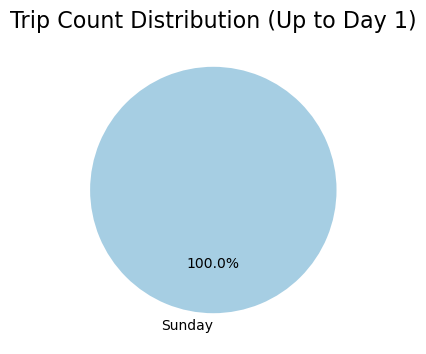

In [728]:
dataframe = get_data_for_visual_3(conn)
df = pd.DataFrame(dataframe)

# Prepare the figure for the animation
fig, ax = plt.subplots(figsize=(6, 4))

# Initial Pie Chart (empty)
def update(frame):
    # Clear the previous plot
    ax.clear()

    # Data for the current frame
    current_data = df.iloc[:frame+1]

    # Plot the pie chart with the current data
    ax.pie(current_data['TripCount'], labels=current_data['DayOfWeek'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    
    # Add a title
    ax.set_title(f"Trip Count Distribution (Up to Day {frame+1})", fontsize=16)

    return ax.patches

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(df), interval=1000, blit=False
)

# Display the animation inline in Jupyter Notebook
display(HTML(ani.to_jshtml()))

# Optionally, save the animation
ani.save("trip_count_pie_animation.mp4", writer="ffmpeg", fps=1)

In [730]:
# Make sure ffmpeg is recognized by matplotlib
plt.rcParams['animation.ffmpeg_path'] = r'C:\path\to\ffmpeg\bin\ffmpeg.exe'